# 1. [50] Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## 1.0. Installing needed libraries

In [18]:
# please read https://github.com/librosa/librosa
!pip install librosa --user

In [ ]:
# you may need ffmpeg to be installed
!conda install -c conda-forge ffmpeg

## 1.1. Reading and resampling audio tracks database

Based on [this librosa demo](https://github.com/librosa/librosa/blob/main/examples/LibROSA%20demo.ipynb). we read audio files in `mp3` format and then resample to common sample rate of 22kHz. 

Make sure you've downloaded all 4 files from [here](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/mp3).

In [1]:
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

audios = ['mp3/ACDC.mp3', 'mp3/iamthemorning.mp3', 'mp3/Little Big.mp3']
request_audio = 'mp3/request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050
# reading all audios
for path in audios:
    dataset[path] = read_and_resample(path, sample_rate)

# reading request audio
request_data = read_and_resample(request_audio, sample_rate)

C:\Users\demo8\AppData\Roaming\Python\Python36\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
C:\Users\demo8\AppData\Roaming\Python\Python36\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


mp3/ACDC.mp3 length is 4.88 min
mp3/iamthemorning.mp3 length is 3.83 min
mp3/Little Big.mp3 length is 2.68 min
mp3/request.mp3 length is 0.17 min


## 1.2. Visualizing example spectrogram

We use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception of pitch rather than normal frequencies. No theoretical basis, just for you to know what is this :)

Spectrogram shape: (128, 12599)


C:\Users\demo8\AppData\Roaming\Python\Python36\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\demo8\AppData\Roaming\Python\Python36\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


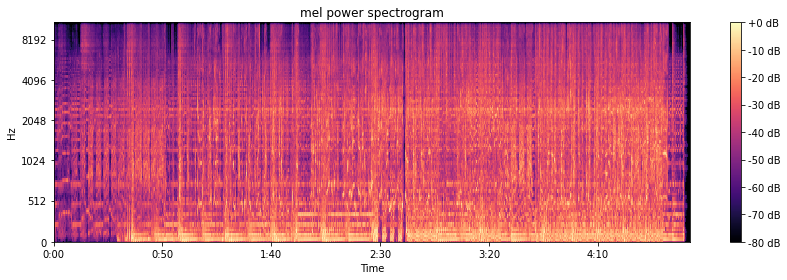

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# 1-D array
y = dataset['mp3/ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

## 1.3. Forming constellations

We will do something like this from our spectrogram. Not exactly as in the paper, but very similar :)

<img src="http://coding-geek.com/wp-content/uploads/2015/05/shazam_filtered_spectrogram-min.png" width="400"/>

This will include:
- get spectrogram
- find local maxima with [computer vision algrithm (wow!)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html): run maximum filtering and then compare original values with filtered.
- `ndimage.label()` labels different connected components
- `ndimage.find_objects()` returns their coordinates
- for each connected component of size 1 (`(dx.stop - dx.start) * (dy.stop - dy.start) == 1`) save a center, which will correspond to a "star"

Time resolution: 0.02321972427354941
mp3/ACDC.mp3
6587
mp3/iamthemorning.mp3
5128
mp3/Little Big.mp3
3479
mp3/request.mp3
234


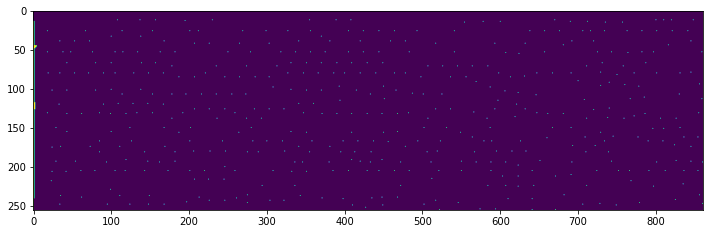

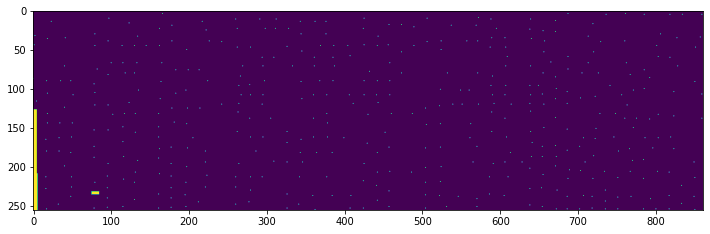

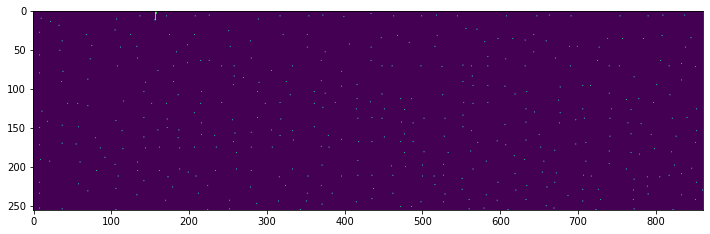

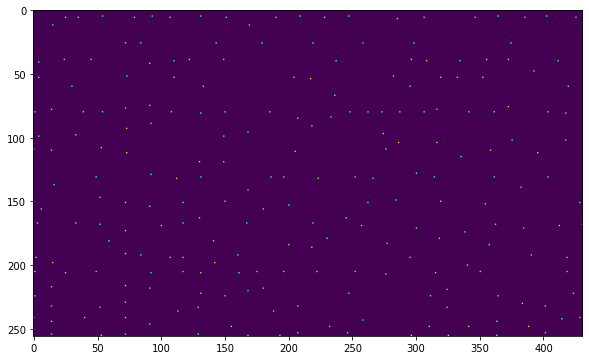

In [4]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["mp3/ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print("Time resolution:", time_resolution)

def form_constellation(name, wav, sample_rate, time_resolution):
    S = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=256, fmax=4000)
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / time_resolution)
    hi = int(20 / time_resolution)
    print(name)
    # here we show results of max filter. This is NOT exactly the same which is saved.
    # Only single-point CC will fall into `points` array
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi])
    plt.show()
    print(len(points))
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate, time_resolution)

request_constellation = form_constellation(request_audio, request_data, sample_rate, time_resolution)

## 1.4. [50] Build index from constellations 

### 1.4.1. [30] Index construction

Here you will build an in-memory index from constellations. Follow the algorithm:
1. For every "star" $(t_1, f_1)$ on constellation consider some constellation window (`target`) of time and frequency shift. In example this is `(+1, +5) sec` and `(-50, +50) Hz`. In original paper they propose to use SOME "stars". If you propose your own selection method - this is also good, as it speeds up computations.
2. If a "star" $(t_2, f_2)$ falls into a `target` window, create or update and index entry. Form a key as $(f1, f2, \Delta t=t_2-t_1)$, and a value is $(t_1, filename)$.

In [35]:
print(time_resolution)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 

index = {}
request = {}

def build_constellation_index(constellation_collection, target):
    time_min = target[0]
    time_max = target[1]
    freq_min = target[2]
    freq_max = target[3]
    result_index = {}
    # For each file
    for file_name in constellation_collection.keys():
        print(f"{file_name} in progress...")
        # List of tuples (t, f)
        constellation = constellation_collection[file_name]
        for star in constellation:
            t1 = star[0]
            f1 = star[1]
            # Find all stars in window
            target_stars = [x for x in constellation if (time_min + t1) <= x[0] <= (time_max + t1) and \
                                                        (freq_min + f1) <= x[1] <= (freq_max + f1)]
            for s in target_stars:
                key = (f1, s[1], s[0] - t1)
                val = (t1, file_name)
                result_index.setdefault(key, []).append(val)
    return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

0.02321972427354941
mp3/ACDC.mp3 in progress...
mp3/iamthemorning.mp3 in progress...
mp3/Little Big.mp3 in progress...
mp3/request.mp3 in progress...


### 1.4.2. [20] Compare `request.mp3` track with the database using index queries.

1. For every audio file from index find all keys that match query keys.
2. for every such match calculate time offset (difference between audio $t_1$ and query $t_1$)
3. Display counts of matches for every time offset (using histogram, for example)

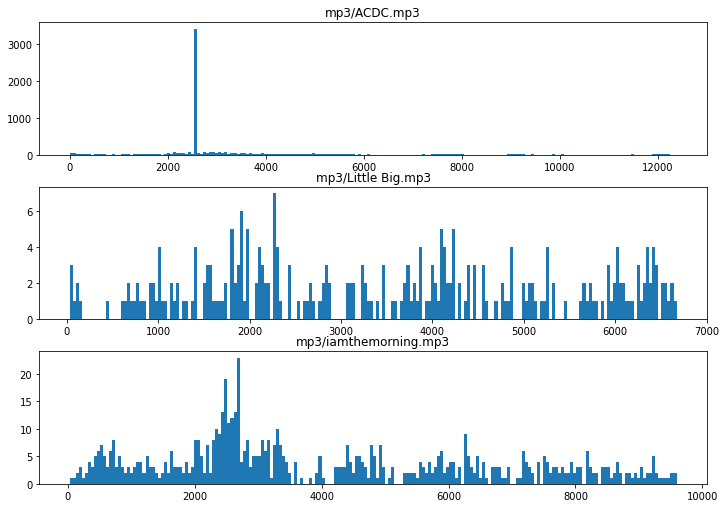

In [42]:
import matplotlib.pyplot as plt

offsets = {}
# Through request
for k in request.keys():
    req_vals = request[k]
    # If found the same key in index, for each pair in value
    for tup in index.setdefault(k, []):
        ind_t1 = tup[0]
        ind_name = tup[1]
        # Add the difference of time to offset with corresponding name
        for req in req_vals:
            offsets.setdefault(ind_name,[]).append(abs(ind_t1 - req[0]))

# Draw a histogram
fig, axs = plt.subplots(3,figsize=(10,7))

plt.tight_layout()
n_bins = 200
i = 0
for key, val in offsets.items():
    axs[i].hist(val, n_bins)
    axs[i].set_title(key)
    i+=1

## 1.4.3. [Extra] Similarity function

Implement a function, which will be estimating similarity of 2 audio tracks in some numbers. It should return 2 numbers: relevance estimation and audio offset (how start of one track is shifted with respect to another, if possible).

We are not giving any particular instructions on HOW to do this, but you can definitely start thinking from:
1. Norming and thresholding.
2. [Mode](https://en.wikipedia.org/wiki/Mode_(statistics)). E.g. [in python](https://docs.python.org/3/library/statistics.html).
3. [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis). E.g. [in python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html).

In [ ]:
def similarity(audio1, audio2):
    
    
    # ... write your code here
    similarity = None
    offset = None
    return similarity, offset


sim, off = similarity('mp3/ACDC.mp3', 'mp3/request.mp3')
assert abs(abs(off) - 60) < 5, "Offset value for these 2 tracks should be around 1 minute."

# 2. [50] Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## 2.1. Get dataset

We will use `Caltech 101` dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## 2.2. SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images (use in your code `cv.drawMatches()` function to display keypoint matches).

In [ ]:
!pip install opencv-python opencv-contrib-python

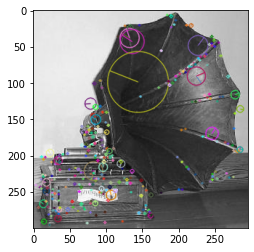

In [12]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = '101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## 2.3. [50] Index of keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, you will index descriptors of all images using some data structure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a new (query) image you will generate its descriptors, and for each of them find its `k` nearest neighbors (using Euclidean or Cosine distance, which you prefer). Finally, you will sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors (more matches -- higher the rank).

### 2.3.1. [30] Build an index

Read all images, saving category information. For every image generate SIFT descriptors and index them using HNSW from [`nmslib`](https://github.com/nmslib/nmslib), FAISS, Annoy or whatever.

In [13]:
import os
from tqdm import tqdm
X = []
y = []
# Add content of files to data set
for root, dir, files in os.walk(img_dir):
    for i in tqdm(files, desc=f"Folder {root}"):
        i_img = cv.cvtColor(cv.imread(os.path.join(root, i)), cv.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(i_img, mask=None)
        X.append(des)
        y.append(os.path.join(root, i))
print(f"Size of data set is {len(X)}")

Folder 101_ObjectCategories: 0it [00:00, ?it/s]
Folder 101_ObjectCategories\yin_yang: 100%|██████████| 60/60 [00:05<00:00, 11.53it/s]


Size of data set is 9145


In [48]:
# Create Annoy index

import numpy as np
from annoy import AnnoyIndex

labels = []
index = AnnoyIndex(128, 'angular')

j = 0
for i in tqdm(range(len(X))):
    # Some image from BACKGROUND_Google is processed by sift, but return None
    if type(X[i]) is not type(None):
        # For each descriptor of image X[i] create a node in AnnoyIndex;
        # take max 100 descriptors because of computation issue
        for desc in X[i][:100]:
            index.add_item(j, desc)
            # i-th picture is a label for this descriptor
            labels.append(i)
            j+=1
    else:
        print(f"Image {y[i]} is broken")
# Could take some time...
index.build(50)
print("Num of items ", index.get_n_items())
print("Num of trees ", index.get_n_trees())

100%|██████████| 9145/9145 [00:40<00:00, 224.43it/s]


Image 101_ObjectCategories\BACKGROUND_Google\image_0031.jpg is broken
Num of items  907393
Num of trees  50


### 2.3.2. [20] Implement search function

Implement a function which returns `k` neighbours (names) sorted for a given image name.

In [49]:
from collections import Counter

def anns(imagename, k):
    paths = []
    # Descriptors of request image
    i_img = cv.cvtColor(cv.imread(os.path.join(img_dir, imagename)), cv.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(i_img, mask=None)

    for desc in descriptors:
        # Nums of descriptors' neighbours
        classes = index.get_nns_by_vector(desc, k)
        # Add path of image of desc
        paths.extend([y[labels[i]] for i in classes])
    # Agregate the most popular paths
    counter = Counter(paths)
    print(f"Prediction: {counter.most_common(k)}")
    return counter.most_common(k)

# Filename in assert was slightly changed

# finds query image in the result, as it is indexed
filename = 'strawberry\\image_0022.jpg'
assert any([filename in f[0] for f in anns(filename, 10)]), "Should return a duplicate"

Prediction: [('101_ObjectCategories\\strawberry\\image_0022.jpg', 112), ('101_ObjectCategories\\pyramid\\image_0050.jpg', 8), ('101_ObjectCategories\\stop_sign\\image_0044.jpg', 6), ('101_ObjectCategories\\joshua_tree\\image_0025.jpg', 5), ('101_ObjectCategories\\BACKGROUND_Google\\image_0194.jpg', 5), ('101_ObjectCategories\\watch\\image_0166.jpg', 5), ('101_ObjectCategories\\BACKGROUND_Google\\image_0063.jpg', 3), ('101_ObjectCategories\\butterfly\\image_0023.jpg', 3), ('101_ObjectCategories\\lamp\\image_0008.jpg', 3), ('101_ObjectCategories\\strawberry\\image_0011.jpg', 3)]


## 2.3.3. [Extra] Estimate quality

Build a bucket from these images.
```
accordion/image_0043.jpg
laptop/image_0052.jpg
pagoda/image_0038.jpg
revolver/image_0043.jpg
rhino/image_0040.jpg
sea_horse/image_0038.jpg
soccer_ball/image_0057.jpg
starfish/image_0011.jpg
strawberry/image_0022.jpg
wrench/image_0013.jpg
```
Consider `relevant` if **class of the query and class of the result match**. Compute `DCG` and `pFound` for every query and for the bucket in average.

In [67]:
import math
# Change only slashes
test_files = ["accordion\\image_0043.jpg", "laptop\\image_0052.jpg", "pagoda\\image_0038.jpg",
              "revolver\\image_0043.jpg", "rhino\\image_0040.jpg", "sea_horse\\image_0038.jpg",
              "soccer_ball\\image_0057.jpg", "starfish\\image_0011.jpg",
              "strawberry\\image_0022.jpg", "wrench\\image_0013.jpg"]


# pFound for one query
def pFound(search_results, relevance):
    pFound = 0
    pBreak = 0.15
    pRel = 0
    pLook = 1
    for i in range(len(search_results)):
        # pRel and pLook from the previous iteration
        pLook = pLook * (1 - pBreak) * (1 - pRel)
        if i in relevance:
            pRel = 0.4
        else:
            pRel = 0
        pFound += pLook * pRel
    return pFound


# NDGG for one query
# Score = 1, if search is relevant;
# 0 otherwise (I don't have labeled relevance)
def NDGG(search_results, relevance):
    NDGG = 0
    for m in range(len(search_results)):
        if m in relevance:
            NDGG += 1 / math.log2(m + 2)
    # Perfect case
    Z = sum([1/math.log2(m + 2) for m in range(len(search_results))]) or 1
    return NDGG / Z


avg_pFound = 0
avg_NDGG = 0

for file in test_files:
    # Class
    label = file.split("\\")[0]
    neighbors = [i[0] for i in anns(file, 10)]
    rel = []
    # Save indexes of matches
    for i in range(len(neighbors)):
        if label in neighbors[i]:
            rel.append(i)
    print(f"Class matching: {rel}")
    avg_pFound += pFound(neighbors, rel)
    avg_NDGG += NDGG(neighbors, rel)

print(f"pFound={avg_pFound/len(test_files)}")
print(f"NDGG={avg_NDGG/len(test_files)}")

Prediction: [('101_ObjectCategories\\accordion\\image_0043.jpg', 111), ('101_ObjectCategories\\accordion\\image_0042.jpg', 31), ('101_ObjectCategories\\accordion\\image_0037.jpg', 25), ('101_ObjectCategories\\accordion\\image_0032.jpg', 19), ('101_ObjectCategories\\accordion\\image_0026.jpg', 18), ('101_ObjectCategories\\Faces_easy\\image_0046.jpg', 17), ('101_ObjectCategories\\BACKGROUND_Google\\image_0042.jpg', 15), ('101_ObjectCategories\\accordion\\image_0033.jpg', 14), ('101_ObjectCategories\\accordion\\image_0022.jpg', 14), ('101_ObjectCategories\\ewer\\image_0006.jpg', 14)]
Class matching: [0, 1, 2, 3, 4, 7, 8]
Prediction: [('101_ObjectCategories\\laptop\\image_0052.jpg', 118), ('101_ObjectCategories\\pizza\\image_0018.jpg', 18), ('101_ObjectCategories\\yin_yang\\image_0060.jpg', 15), ('101_ObjectCategories\\Faces\\image_0284.jpg', 14), ('101_ObjectCategories\\laptop\\image_0038.jpg', 13), ('101_ObjectCategories\\grand_piano\\image_0079.jpg', 11), ('101_ObjectCategories\\BACKGRO